In [21]:
import networkx as nx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit import QuantumCircuit
from qiskit.circuit import Measure
from qiskit.quantum_info import Operator

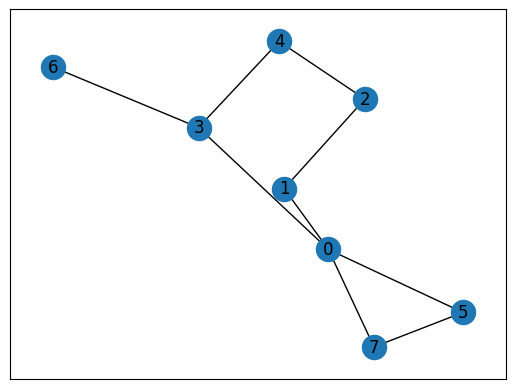

In [22]:
G = nx.Graph()
G.add_edges_from([[0,1],[0,3],[0,5],[0,7],[5,7],[1,2],[2,4],[3,4],[3,6]])
nx.draw_networkx(G)

In [23]:
operator = SparsePauliOp.from_list(
    [("IIIIIIZZ", 0.5), 
     ("IIIIZIIZ", 0.5), 
     ("IIZIIIIZ", 0.5), 
     ("ZIIIIIIZ", 0.5), 
     ("ZIZIIIII", 0.5), 
     ("IIIIIZZI", 0.5), 
     ("IIIZIZII", 0.5), 
     ("IIIZZIII", 0.5), 
     ("IZIIZIII", 0.5),]
)

print("Cost Function Hamiltonian:", operator)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIIZZ', 'IIIIZIIZ', 'IIZIIIIZ', 'ZIIIIIIZ', 'ZIZIIIII', 'IIIIIZZI', 'IIIZIZII', 'IIIZZIII', 'IZIIZIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


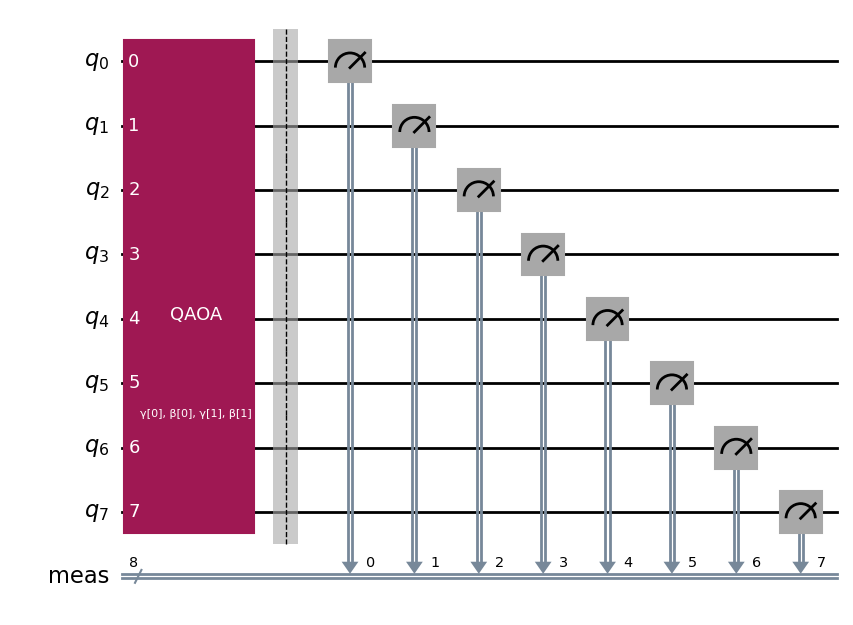

In [24]:
circuit = QAOAAnsatz(cost_operator=operator, reps=2)

circuit.measure_all()
circuit.draw('mpl')

In [25]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

C:\Users\P39686820\AppData\Local\Temp\ipykernel_19608\4210555755.py:4: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel='ibm_quantum')


<IBMBackend('ibm_brisbane')>


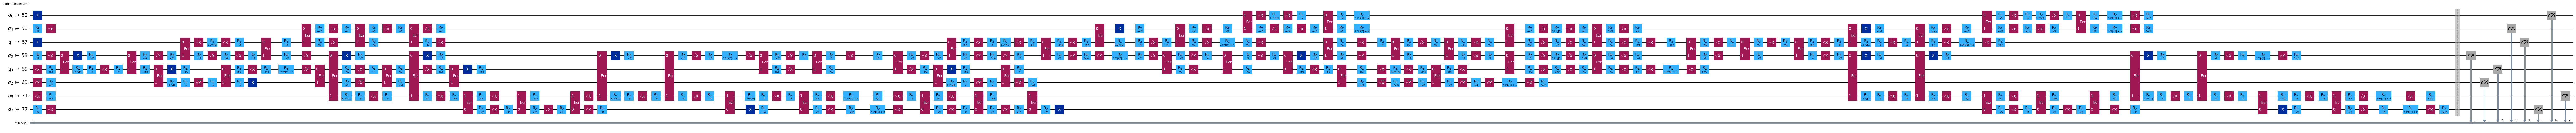

In [26]:
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(circuit)
isa_operator = operator.apply_layout(isa_circuit.layout)

isa_circuit.draw('mpl', fold=False, idle_wires=False)

In [27]:
import numpy as np
num_params = circuit.num_parameters
x0 = 0.5* np.pi * np.random.random(num_params)
print(x0)

[0.63293705 0.64647512 0.85821013 0.9380112 ]


In [28]:
def cost_func(params, ansatz, hamiltonian, estimator):
    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])
    results = job.result()[0]
    cost = results.data.evs
    cost_values.append(cost)
    print(cost)
    return cost

In [33]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize

cost_values = []

with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
    
    result = minimize(
        cost_func,
        x0,
        args=(isa_circuit, isa_operator, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

0.3844647260828088
0.1942317488572048
0.3114295439571584
-0.07547362957433332
0.3310210958956496
0.42913055088238905
-0.42680747818759157
-0.09896638002781641
-0.2532074075276343
0.04758306633002146
-0.2903486854803864
-0.08290700197950958
-0.07386639219998448
-0.3015992281707053


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cost_values)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [ ]:
optimized_circuit = isa_circuit.assign_parameters(result.x)

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts = job.result()[0].data.meas.get_counts()

In [ ]:
shots = 10000

sampler = Sampler(mode=my_backend)
sampler.options.default_shots = shots

pub= (optimized_circuit, )
job = sampler.run([pub], shots=shots)
counts = job.result()[0].data.meas.get_counts()

In [ ]:
keys = list(counts.keys())
values = list(counts.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bits = [int(digit) for digit in most_likely]
most_likely_bits.reverse()

print(most_likely_bits)

In [ ]:
colors = []
for node in G:
    if most_likely_bits[node]==0:
        colors.append("red")
    else:
        colors.append("green")

In [ ]:
nx.draw_networkx(G,node_color = colors)